In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

In [2]:
ANNOTATIONS_FOLDER = os.path.join('.', 'dataset', 'annotations')
IMAGES_FOLDER = os.path.join('.', 'dataset', 'images')
DATASET_ROOT_FOLDER = os.path.join('.', 'dataset')

DATASET_YOLO_ROOT_FOLDER = os.path.join('.', 'dataset_yolo')
DATASET_YOLO_IMAGES = os.path.join(DATASET_YOLO_ROOT_FOLDER, 'images')
DATASET_YOLO_IMAGES_TRAIN = os.path.join(DATASET_YOLO_IMAGES, 'train')
DATASET_YOLO_IMAGES_VAL = os.path.join(DATASET_YOLO_IMAGES, 'val')

DATASET_YOLO_LABELS = os.path.join(DATASET_YOLO_ROOT_FOLDER, 'labels')
DATASET_YOLO_LABELS_TRAIN = os.path.join(DATASET_YOLO_LABELS, 'train')
DATASET_YOLO_LABELS_VAL = os.path.join(DATASET_YOLO_LABELS, 'val')

OUTPUT_FOLDER = os.path.join('.', 'output')

In [3]:
import re

annotations_paths = sorted(
    [os.path.join(ANNOTATIONS_FOLDER, xml_name) for xml_name in os.listdir(ANNOTATIONS_FOLDER)], 
    key=lambda x: int(re.search(r'\d+', x).group())
)

In [4]:
import xml.etree.ElementTree as ET

parsed_annotations = []

for xml_path in annotations_paths:
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    filename = root.find('filename').text
    
    size_node = root.find('size')
    width = int(size_node.find('width').text)
    height = int(size_node.find('height').text)
    
    object_node = root.find('object')
    bnd_node = object_node.find('bndbox')
    
    ymin = int(bnd_node.find('ymin').text)
    xmin = int(bnd_node.find('xmin').text)
    ymax = int(bnd_node.find('ymax').text)
    xmax = int(bnd_node.find('xmax').text)
    
    annotation_data = {
        'image_name': filename,
        'width': width,
        'height': height,
        'ymin': ymin,
        'xmin': xmin,
        'ymax': ymax,
        'xmax': xmax
    }
    
    parsed_annotations.append(annotation_data)
    
df = pd.DataFrame(parsed_annotations)

(-0.5, 441.5, 332.5, -0.5)

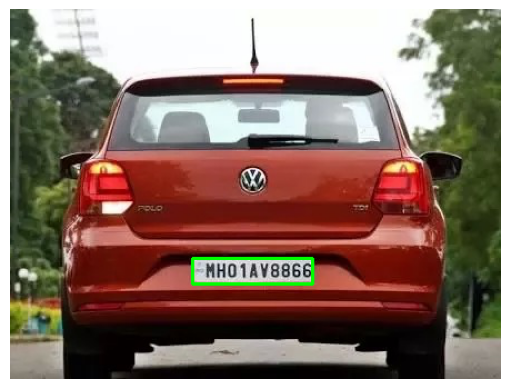

In [5]:
sample_image_row = df.iloc[9]

sample_image = cv2.imread(os.path.join(IMAGES_FOLDER, sample_image_row['image_name']))
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

ymin = sample_image_row['ymin']
xmin = sample_image_row['xmin']
ymax = sample_image_row['ymax']
xmax = sample_image_row['xmax']

cv2.rectangle(sample_image_rgb, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(sample_image_rgb)
plt.axis('off')

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=24)

In [7]:
print(f'df train length: {df_train.shape[0]}')
print(f'df val length: {df_val.shape[0]}')
print(f'df test length: {df_test.shape[0]}')

df train length: 311
df val length: 35
df test length: 87


In [8]:
df_test.head(10)

image_name  width  height  ymin  xmin  ymax  xmax
425  Cars425.png    500     232   103   211   132   301
75    Cars75.png    400     248   196   209   201   218
181  Cars181.png    225     400   195    69   209   128
30    Cars30.png    400     240   169   155   182   200
364  Cars364.png    400     242   140    61   167   115
408  Cars408.png    400     267   217   160   228   187
253  Cars253.png    400     210   124    25   137    64
155  Cars155.png    400     267   177   150   190   203
168  Cars168.png    400     225    95    82   125   137
415  Cars415.png    400     300   157   133   192   261

In [9]:
df_val

image_name  width  height  ymin  xmin  ymax  xmax
260  Cars260.png    400     240   112   170   129   232
91    Cars91.png    400     253   170   269   189   317
4      Cars4.png    590     350    82   156   253   503
67    Cars67.png    553     275   223   189   248   328
172  Cars172.png    457     422   209   173   239   301
58    Cars58.png    400     247   166   154   187   241
221  Cars221.png    400     225   122   102   135   125
304  Cars304.png    400     226   114   143   156   222
322  Cars322.png    400     354   257   274   297   350
74    Cars74.png    400     267   115   115   153   277
420  Cars420.png    400     300   186   112   211   160
332  Cars332.png    400     225   126   143   159   260
275  Cars275.png    400     215   150    99   167   162
251  Cars251.png    400     225   134   136   153   210
141  Cars141.png    400     267   169   266   188   307
346  Cars346.png    400     246   185    91   217   197
234  Cars234.png    400     233   149   160   171   246
334  Cars334.png    400     204   146   155   162   211
139  Cars139.png    400     300   189   315   197   337
293  Cars293.png    400     267   160    64   181   130
54    Cars54.png    400     300    61   148   118   257
423  Cars423.png    400     250   159   162   183   283
315  Cars315.png    400     300    98    12   181   385
308  Cars308.png    400     300   221   159   241   237
210  Cars210.png    400     266    90    54   159   315
264  Cars264.png    400     400   300   222   337   295
131  Cars131.png    500     300    29    19   245   497
243  Cars243.png    600     450   174   129   235   465
37    Cars37.png    400     268   114   146   163   246
375  Cars375.png    400     300   114   144   145   300
132  Cars132.png    400     225   190    23   198    56
216  Cars216.png    530     398   214   205   262   280
291  Cars291.png    517     303   205    71   246   215
386  Cars386.png    600     450   307    83   368   221
290  Cars290.png    400     267    84   224   118   271

In [10]:
def mkdir_yolo_dataset_folder(root_folder=DATASET_YOLO_ROOT_FOLDER):
    images_folder = os.path.join(root_folder, 'images')
    labels_folder = os.path.join(root_folder, 'labels')
    
    train_images_folder = os.path.join(images_folder, 'train')
    val_images_folder = os.path.join(images_folder, 'val')
    
    train_labels_folder = os.path.join(labels_folder, 'train')
    val_labels_folder = os.path.join(labels_folder, 'val')

    os.makedirs(root_folder, exist_ok=True)
    
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(labels_folder, exist_ok=True)
    
    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(val_images_folder, exist_ok=True)
    
    os.makedirs(train_labels_folder, exist_ok=True)
    os.makedirs(val_labels_folder, exist_ok=True)

In [11]:
mkdir_yolo_dataset_folder()

In [12]:
import shutil

def init_yolo_images_folder(df, src_folder, dest_folder):
    for image_name in df['image_name']:
        src_path = os.path.join(src_folder, image_name)
        dest_path = os.path.join(dest_folder, image_name)
        
        if os.path.exists(dest_path):
            continue
            
        shutil.copy2(src_path, dest_path)

In [13]:
init_yolo_images_folder(df_train, IMAGES_FOLDER, DATASET_YOLO_IMAGES_TRAIN)
init_yolo_images_folder(df_val, IMAGES_FOLDER, DATASET_YOLO_IMAGES_VAL)

In [14]:
def init_yolo_labels_folder(df, dest_folder):
    for _, row in df.iterrows():
        width = row['width']
        height = row['height']
        
        relative_x_center = (row['xmin'] + row['xmax']) / (2 * width)
        relative_y_center = (row['ymin'] + row['ymax']) / (2 * height)
        
        relative_width = (row['xmax'] - row['xmin']) / width
        relative_height = (row['ymax'] - row['ymin']) / height
        
        label_path = os.path.join(dest_folder, row['image_name'].split('.')[0]) + '.txt'
        
        with open(label_path, 'w') as f:
            line = f'{0} {relative_x_center} {relative_y_center} {relative_width} {relative_height}'
            f.write(line)

In [15]:
init_yolo_labels_folder(df_train, DATASET_YOLO_LABELS_TRAIN)
init_yolo_labels_folder(df_val, DATASET_YOLO_LABELS_VAL)

In [16]:
YOLO_DATASET_CONFIGURATION_NAME = 'yolo_dataset.yml'
YOLO_DATASET_CONFIGURATION = {
    'path': DATASET_YOLO_ROOT_FOLDER,
    'train': os.path.join('.', 'images', 'train'),
    'val': os.path.join('.', 'images', 'val'),
    'nc': 1,
    'names': ['car_license_plate']
}

YOLO_DATASET_PATH_TO_CONFIGURATION = os.path.join(DATASET_YOLO_ROOT_FOLDER, YOLO_DATASET_CONFIGURATION_NAME)

In [17]:
import yaml

with open(YOLO_DATASET_PATH_TO_CONFIGURATION, 'w') as f:
    yaml.dump(YOLO_DATASET_CONFIGURATION, f)

In [18]:
print(f'Is CUDA available: {torch.cuda.is_available()}')

Is CUDA available: True


In [10]:
model = YOLO("yolov8n.pt")

In [20]:
n_epochs = 100
batch_size = 32

In [21]:
torch.cuda.reset_peak_memory_stats()

model.train(
    data=YOLO_DATASET_PATH_TO_CONFIGURATION,
    epochs=n_epochs,
    batch=batch_size,
    imgsz=640,
    device=[0]
)

New https://pypi.org/project/ultralytics/8.3.130 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.128  Python-3.10.7 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=.\dataset_yolo\yolo_dataset.yml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, o

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.6MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 492.6217.1 MB/s, size: 475.3 KB)


train: Scanning C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\dataset_yolo\labels\train.cache... 311 images, 0 backgrounds, 0 corrupt: 100%|██████████| 311/311 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 392.474.1 MB/s, size: 504.6 KB)


val: Scanning C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\dataset_yolo\labels\val.cache... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<?, ?it/s]


Plotting labels to C:\Data\University\master\master_1_year_sem_2\neurocomputing\runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Data\University\master\master_1_year_sem_2\neurocomputing\runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.64G      1.605      3.973      1.507         44        640: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         35         35    0.00286      0.857      0.289      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.65G      1.396      2.426      1.187         55        640: 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         35         35    0.00276      0.829      0.491      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.65G      1.452      1.967      1.227         49        640: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all         35         35    0.00257      0.771     0.0704     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.65G      1.413        1.9      1.181         37        640: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         35         35    0.00267        0.8       0.13     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.65G      1.448      1.807      1.214         39        640: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         35         35      0.131      0.114     0.0615     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.65G       1.46      1.698       1.23         49        640: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         35         35      0.351      0.229      0.184     0.0711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.65G      1.417       1.59      1.232         58        640: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         35         35       0.54      0.114      0.124     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.65G      1.386      1.494      1.183         40        640: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         35         35      0.422      0.257      0.282      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.65G      1.446      1.424      1.233         36        640: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         35         35      0.589        0.2      0.257      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.65G      1.383      1.356      1.178         53        640: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         35         35      0.421      0.229      0.222     0.0805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.65G      1.403      1.322      1.225         36        640: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         35         35      0.623      0.142      0.158     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.65G      1.369      1.263      1.204         38        640: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         35         35       0.43      0.257      0.247      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.65G      1.399      1.238      1.212         41        640: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         35         35      0.692      0.543      0.549      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.65G      1.328      1.171      1.212         50        640: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         35         35          1      0.593      0.674      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.65G      1.366      1.126      1.208         52        640: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         35         35      0.627      0.514       0.48      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.65G      1.381      1.128       1.25         30        640: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         35         35      0.877      0.486      0.565      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.65G      1.326      1.023      1.206         34        640: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         35         35      0.825      0.672      0.719      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.65G      1.308      1.018      1.181         40        640: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         35         35      0.746      0.771      0.745      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.65G      1.346       1.03      1.217         43        640: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         35         35      0.871      0.771      0.841      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.65G      1.302     0.9557      1.185         39        640: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         35         35      0.863      0.722      0.805      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.65G      1.373     0.9886       1.18         52        640: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         35         35      0.822       0.79      0.836       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.65G      1.325     0.9962      1.191         38        640: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         35         35      0.878      0.686      0.846      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.65G      1.289       0.92      1.134         49        640: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35         35      0.802      0.829      0.868      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.65G      1.303     0.9137      1.182         37        640: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         35         35      0.869      0.743      0.785      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.65G      1.267     0.9157      1.181         49        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35         35      0.882      0.851      0.846      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.65G      1.268     0.8739      1.167         42        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         35         35      0.858      0.771      0.874      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.65G      1.297     0.8631      1.158         52        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35         35      0.834      0.862      0.866      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.65G      1.195     0.8651      1.117         42        640: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35         35      0.954      0.886      0.904      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.65G      1.186     0.8263      1.148         36        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         35         35      0.877      0.812       0.86      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.65G       1.22     0.8479      1.155         58        640: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         35         35        0.8      0.857      0.824      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.65G      1.256      0.832      1.155         37        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         35         35      0.852      0.886      0.887      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.65G      1.178     0.7753      1.133         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         35         35      0.965       0.79      0.829      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.65G      1.202     0.8208      1.122         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         35         35      0.976      0.771      0.912      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.65G      1.201     0.7575      1.104         43        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         35         35      0.954      0.743      0.902      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.65G      1.218     0.7896       1.14         42        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35         35      0.872      0.857      0.923      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.65G      1.161     0.7619      1.108         36        640: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35         35      0.944      0.686      0.858      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.65G      1.165     0.7276      1.118         46        640: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         35         35      0.895      0.857      0.936      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.65G       1.19     0.7426      1.103         46        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         35         35      0.851      0.829      0.878      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.65G      1.201     0.7508      1.131         47        640: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         35         35      0.776      0.891      0.913      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.65G       1.15     0.7332      1.108         46        640: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         35         35      0.909      0.886      0.926      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.65G       1.16     0.7185      1.114         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         35         35      0.986      0.714      0.846      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.65G      1.145     0.7152      1.123         42        640: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         35         35      0.903      0.829      0.894       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.65G      1.118     0.7154      1.105         46        640: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         35         35      0.905      0.886      0.928      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.65G      1.134     0.7035      1.115         36        640: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         35         35      0.929      0.829      0.869      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.65G      1.162     0.7086      1.113         54        640: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         35         35      0.923        0.8      0.875      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.65G      1.154     0.6954      1.109         52        640: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         35         35      0.906      0.714      0.815      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.65G      1.123     0.6901      1.082         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         35         35       0.93       0.76      0.844      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.65G       1.05     0.6506      1.046         39        640: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         35         35      0.923      0.829      0.881       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.65G      1.073       0.65      1.079         43        640: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         35         35      0.852      0.824        0.9      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.65G      1.075      0.667      1.064         45        640: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         35         35      0.894      0.857        0.9      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.65G      1.117     0.7024      1.089         40        640: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         35         35      0.873      0.857      0.903      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.65G      1.059     0.6278      1.058         53        640: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         35         35      0.923      0.857       0.92      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.65G      1.081     0.6536       1.09         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         35         35      0.914      0.913      0.919      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.65G      1.012     0.6299      1.043         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         35         35      0.967       0.85      0.926       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.65G      1.053     0.6295      1.074         38        640: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         35         35      0.925      0.886      0.942      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.65G      1.058     0.6333      1.075         44        640: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         35         35      0.966      0.821      0.921      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.65G      1.035      0.639      1.051         45        640: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         35         35      0.878      0.886      0.926      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.65G      1.036     0.6559      1.069         43        640: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         35         35      0.909      0.857      0.898      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.65G      1.046     0.6286      1.067         39        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         35         35       0.93      0.829      0.925      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.65G     0.9813      0.621      1.028         53        640: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         35         35      0.963      0.857      0.934        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.65G          1     0.5901      1.022         45        640: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         35         35      0.932      0.857      0.914      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.65G     0.9966     0.6174      1.052         48        640: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         35         35      0.934      0.914      0.927      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.65G     0.9974     0.6172      1.062         37        640: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         35         35      0.882      0.914      0.933      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.65G      1.007     0.6053      1.042         40        640: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         35         35      0.906      0.886      0.935      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.65G     0.9305     0.5732      1.007         48        640: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         35         35      0.914      0.907      0.924      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.65G     0.9657      0.575      1.025         38        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         35         35      0.913      0.898       0.94      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.65G     0.9587     0.5567      1.015         48        640: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all         35         35      0.936      0.886      0.942      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.65G     0.9556     0.5599      1.022         44        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         35         35      0.934      0.857      0.892      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.65G     0.9432     0.5576      1.013         47        640: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         35         35      0.988      0.829      0.925      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.65G     0.9435     0.5512      1.024         44        640: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         35         35      0.938      0.886      0.951      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.65G     0.9252     0.5566      1.019         46        640: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         35         35      0.914      0.943       0.96      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.65G     0.9478     0.5476      1.041         45        640: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         35         35      0.934      0.914      0.958      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.65G     0.9237     0.5423      1.033         44        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         35         35      0.891      0.937      0.947      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.65G     0.9376     0.5464      1.024         43        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         35         35      0.865      0.916      0.938      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.65G     0.9133     0.5365      1.021         37        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         35         35      0.957      0.771      0.899      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.65G     0.9238      0.557      1.043         39        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         35         35      0.935      0.821      0.901      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.65G     0.8996     0.5103      1.027         48        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         35         35      0.908       0.85      0.897      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.65G     0.8989     0.5362      1.018         49        640: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         35         35      0.856      0.914      0.912      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.65G     0.8969     0.5159      1.009         37        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         35         35      0.882      0.914      0.946      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.65G     0.9116     0.5277      1.022         48        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         35         35      0.917      0.857      0.955      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.65G     0.8534     0.5308     0.9871         42        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         35         35      0.921      0.857      0.933      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.65G     0.8601     0.5094     0.9797         43        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         35         35      0.939      0.857      0.933      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.65G     0.8443     0.4944     0.9912         47        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         35         35      0.968      0.858      0.959      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.65G      0.858     0.4959      0.981         48        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         35         35      0.969      0.883      0.946      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.65G     0.8731      0.504     0.9933         51        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         35         35      0.955      0.857      0.922      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.65G     0.8616     0.5069      1.006         44        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         35         35      0.967      0.844      0.919      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.65G     0.8462     0.4893     0.9979         38        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         35         35      0.936      0.857      0.917      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.65G     0.8367     0.4939     0.9884         39        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         35         35      0.967      0.849      0.915      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.65G     0.8283     0.4715     0.9869         47        640: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         35         35       0.96      0.829      0.913      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.65G     0.8299     0.4842     0.9895         51        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         35         35      0.967      0.846      0.938       0.62


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.65G     0.8157      0.491     0.9816         23        640: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         35         35      0.954      0.857       0.94      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.65G     0.7762     0.4532     0.9723         22        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         35         35      0.867      0.934      0.944       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.65G     0.7857     0.4498     0.9733         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         35         35      0.945      0.886      0.946      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.65G     0.7725     0.4366     0.9565         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         35         35      0.961      0.886      0.944      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.65G     0.7714     0.4425     0.9855         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         35         35       0.96      0.886      0.946      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.65G     0.7519      0.443     0.9532         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         35         35      0.958      0.886      0.944      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.65G     0.7381     0.4197     0.9597         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         35         35      0.969      0.883      0.944      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.65G     0.7473     0.4273     0.9568         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         35         35      0.968      0.877      0.941      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.65G     0.7411     0.4312     0.9487         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         35         35      0.969      0.881      0.942       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.65G     0.7123     0.4269     0.9387         23        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         35         35      0.961      0.886      0.942      0.656



100 epochs completed in 0.259 hours.
Optimizer stripped from C:\Data\University\master\master_1_year_sem_2\neurocomputing\runs\detect\train2\weights\last.pt, 6.3MB
Optimizer stripped from C:\Data\University\master\master_1_year_sem_2\neurocomputing\runs\detect\train2\weights\best.pt, 6.3MB

Validating C:\Data\University\master\master_1_year_sem_2\neurocomputing\runs\detect\train2\weights\best.pt...
Ultralytics 8.3.128  Python-3.10.7 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


                   all         35         35      0.961      0.886      0.942      0.653
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to C:\Data\University\master\master_1_year_sem_2\neurocomputing\runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001BB02023C70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [22]:
print(f'Peak of GPU memory consumption: {torch.cuda.max_memory_allocated() / 1024 ** 2:.2f} MB')

Peak of GPU memory consumption: 3595.98 MB


In [23]:
model.save(os.path.join(OUTPUT_FOLDER, 'model_yolo.pt'))

In [25]:
X_test = []
y_test = []

for _, row in df_test.head(40).iterrows():
    src_image = cv2.imread(os.path.join(IMAGES_FOLDER, row['image_name']))
    box = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
    
    X_test.append(np.array(src_image))
    y_test.append(np.array(box))

In [19]:
model = YOLO('./output/model_yolo.pt')

In [20]:
model.load('./output/model_yolo.pt')

Transferred 355/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [16]:
def predict(model, image):
    predictions = model.predict(image)
    
    if len(predictions) == 0 or len(predictions[0]) == 0:
        return []
    
    pred = predictions[0]
    box = pred[0].boxes[0]

    x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
    
    return [x_min, y_min, x_max, y_max]

In [21]:
predict(model, './dataset/images/Cars2.png')


image 1/1 C:\Data\University\master\master_1_year_sem_2\neurocomputing\neurocomputing-lab\dataset\images\Cars2.png: 640x640 1 car_license_plate, 95.6ms
Speed: 6.5ms preprocess, 95.6ms inference, 113.8ms postprocess per image at shape (1, 3, 640, 640)


[227, 173, 272, 194]

In [29]:
# [x_min, y_min, x_max, y_max]
def intersection_over_union(predicted_box, actual_box):
    if len(predicted_box) == 0 or len(actual_box) == 0:
        return 0.0
    
    pred_x_min, pred_y_min, pred_x_max, pred_y_max = predicted_box
    act_x_min, act_y_min, act_x_max, act_y_max = actual_box
    
    pred_area = (pred_x_max - pred_x_min) * (pred_y_max - pred_y_min)
    act_area = (act_x_max - act_x_min) * (act_y_max - act_y_min)
    
    inter_x_min = max(pred_x_min, act_x_min)
    inter_y_min = max(pred_y_min, act_y_min)
    inter_x_max = min(pred_x_max, act_x_max)
    inter_y_max = min(pred_y_max, act_y_max)
    
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection_area = inter_width * inter_height
    
    union_area = pred_area + act_area - intersection_area
    
    iou = intersection_area / union_area if union_area > 0 else 0.0
    
    return iou


0: 320x640 1 car_license_plate, 46.6ms
Speed: 4.5ms preprocess, 46.6ms inference, 4.5ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 (no detections), 61.3ms
Speed: 3.9ms preprocess, 61.3ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)

0: 640x384 1 car_license_plate, 43.0ms
Speed: 3.2ms preprocess, 43.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 2 car_license_plates, 61.6ms
Speed: 3.2ms preprocess, 61.6ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 1 car_license_plate, 66.6ms
Speed: 3.4ms preprocess, 66.6ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)

0: 448x640 2 car_license_plates, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 1 car_license_plate, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 1 car_license_plate, 6.8ms
Speed:

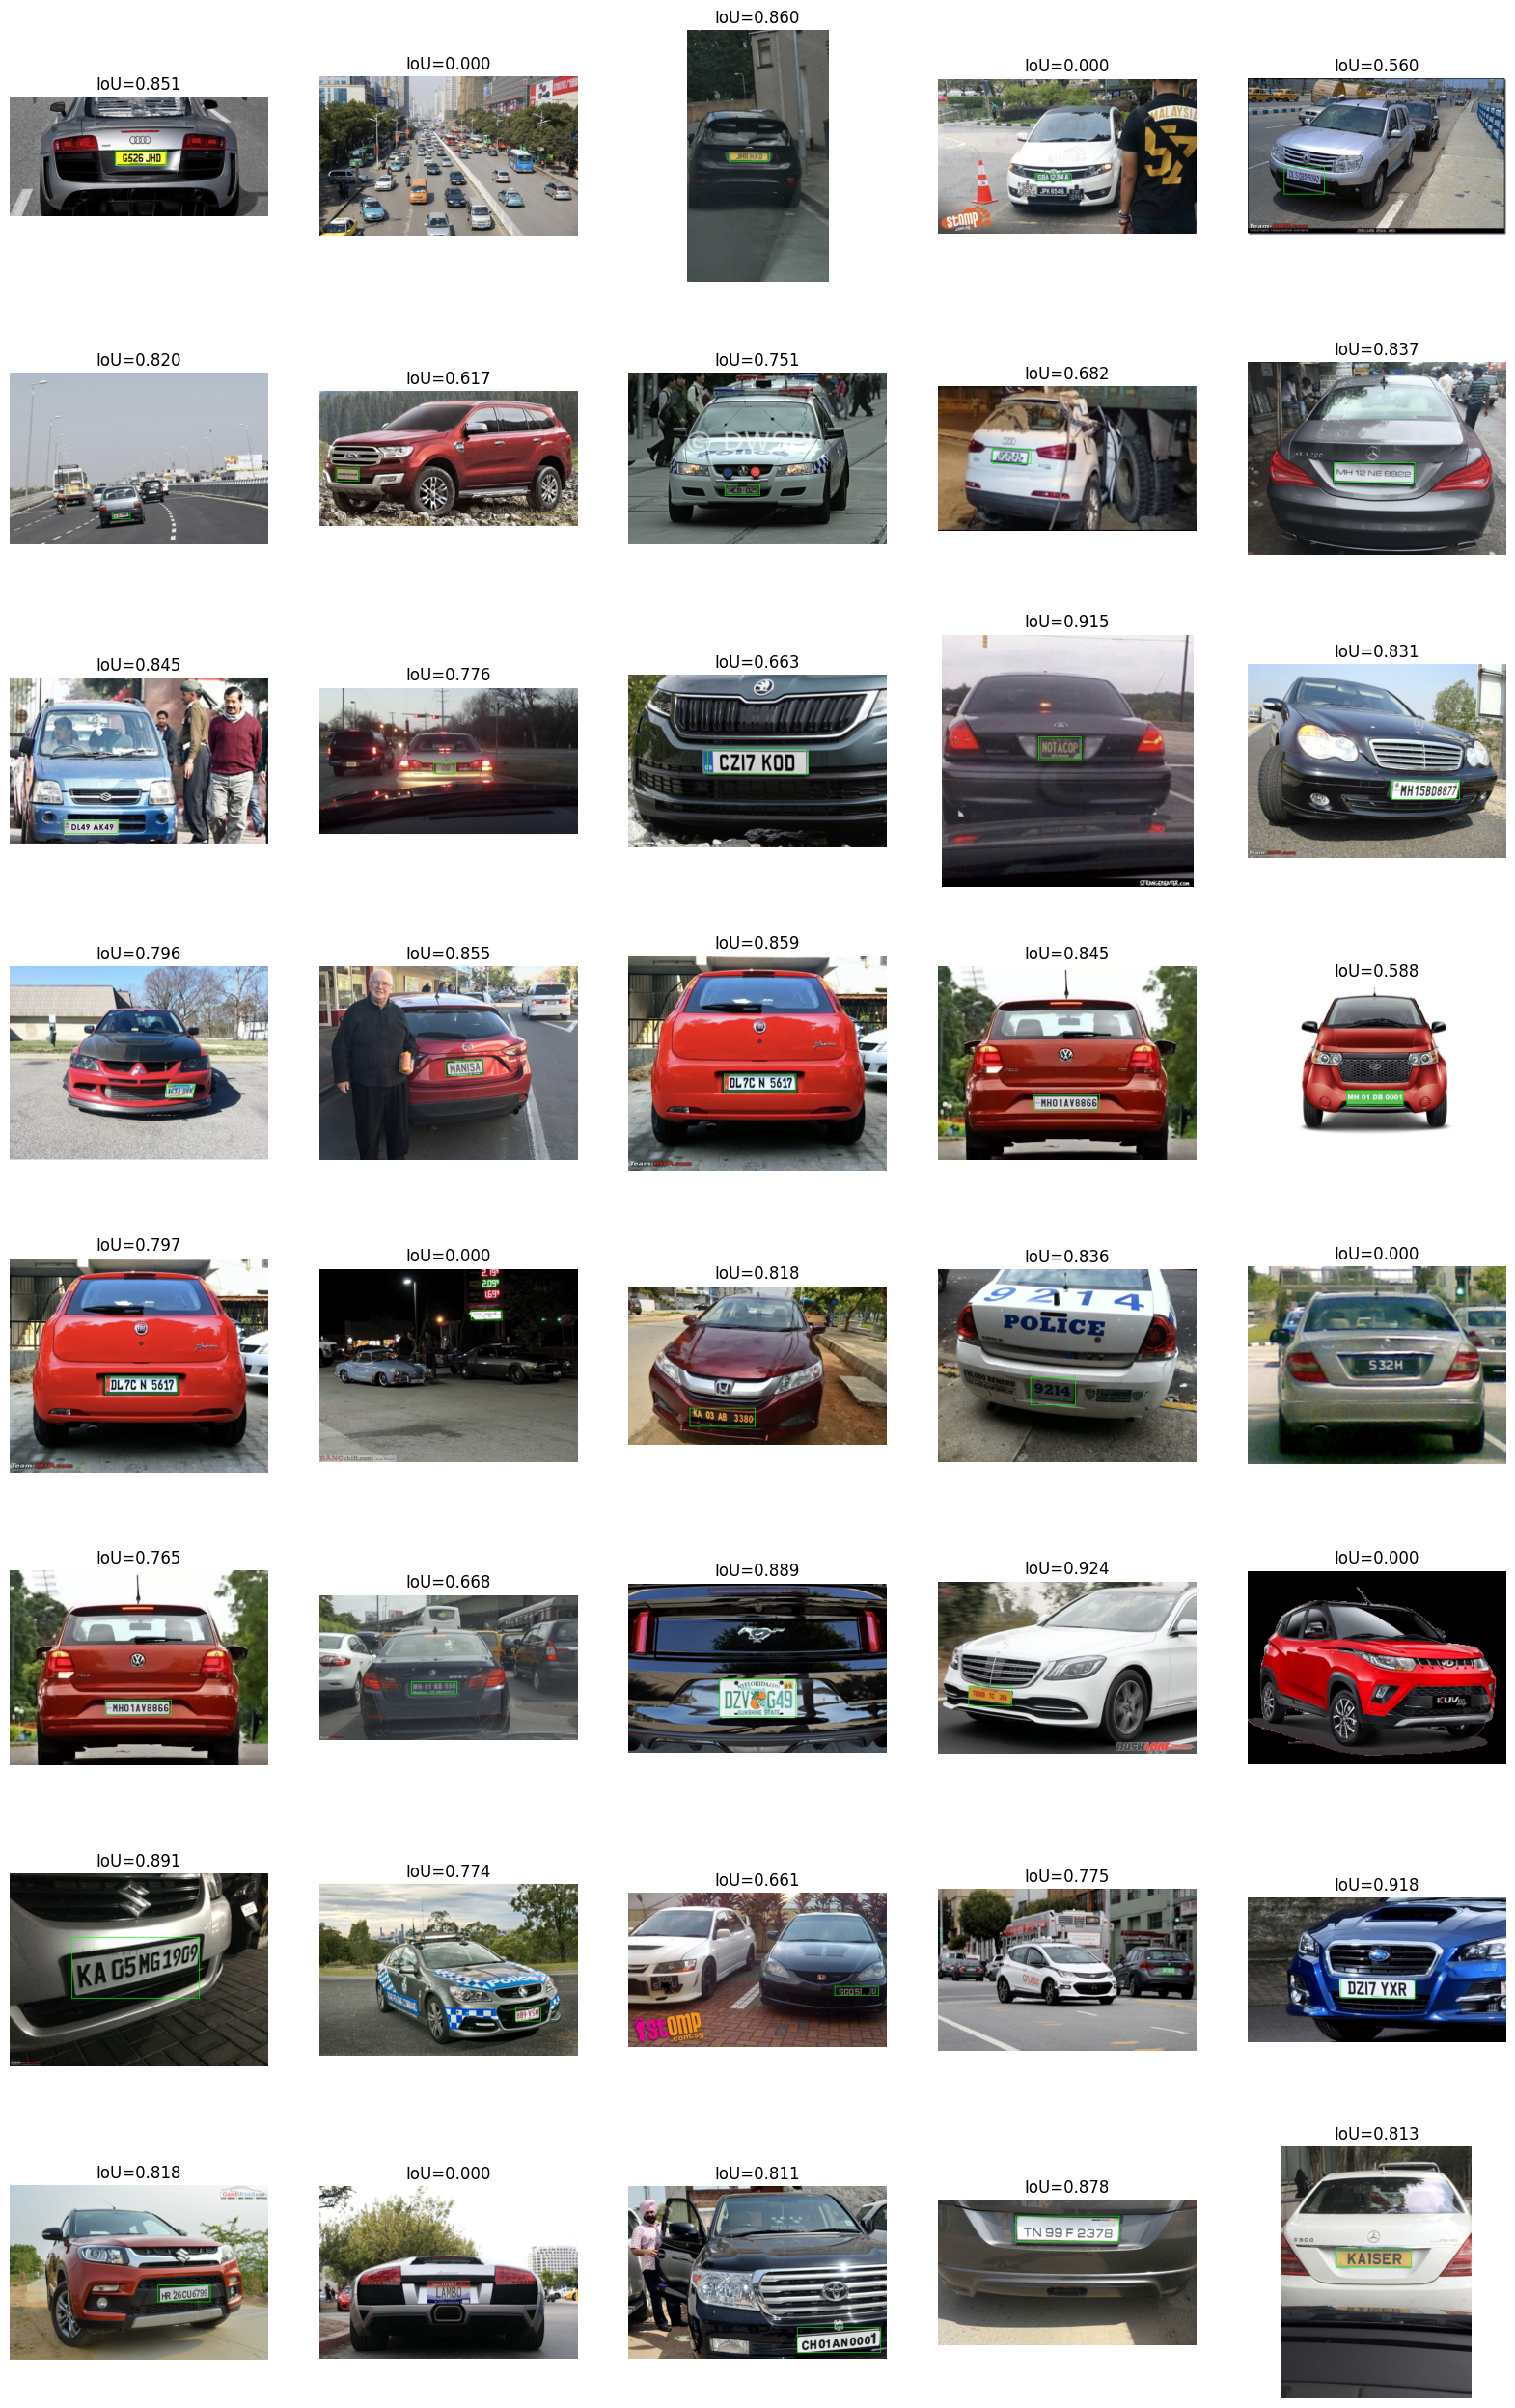

In [32]:
plt.figure(figsize=(20, 40))

iou_values = []

for i in range(0, 40):
    cur_image = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)
    box = predict(model, cur_image)
    iou_i = intersection_over_union(box, y_test[i])
    iou_values.append(iou_i)
    
    if len(box) != 0:
        cur_image = cv2.rectangle(
            cur_image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0)
        )
    
    plt.subplot(10, 5, i + 1)
    plt.axis('off')
    plt.imshow(cur_image)
    plt.title(f'IoU={iou_i:.3f}')
    
print(f'Average IoU: {sum(iou_values) / len(iou_values):.3f}')